# Lab 1. Multi-armed bandits

Alex Carrillo Alza

_Aprenentatge per Reforç i Aprenentatge Profund, Ciència i Enginyeria de Dades (UPC)_

October 6, 2020



Multi-armed bandit (MAB) framework has attracted a lot of attention in various applications, from recommender systems and information retrieval to healthcare and finance, due to its stellar performance combined with certain attractive properties, such as learning from less feedback. The multi-armed bandit field is currently flourishing, as novel problem settings and algorithms motivated by various practical applications are being introduced.

If you are not familiar with Google Colab, follow first [this tutorial](https://colab.research.google.com/notebooks/welcome.ipynb?hl=en).

1. Copy the Phython source code in the Atenea webpage into a Google Drive folder and open it in Google Colab. Read the code in the notebook run, analyze and compare the results.

2. Use the Python code provided as a basis to include your own code and solve the next questions:

## Own code: modifications, parametrizations and refinement

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
np.random.seed(1234)

### Enhance plot functions 

In [69]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def generate_plot(r, ba, q, rewards, re, m, NRuns, NSteps, strg, par, bandit, meanA='', dispMeansA='', dispStd='', probs='', show_rewards = False):
    str_legend = ['{}, {}={}'.format(strg, 'c' if strg == 'UCB' else 'delta', p) for p in par]
    #str_legend = ['{}, {}={}'.format('UCB' if strg else 'e-greedy', 'c' if strg else 'delta', p) for p in par]

    conf_1 = {'title': 'Average reward', 'xlabel': 'steps', 'ylabel': 'avg reward'}
    conf_2 = {'title': 'Percentage optimal actions', 'xlabel': 'steps', 'ylabel': '% optimal actions'}
    conf_3 = {'title': 'Average regret', 'xlabel': 'steps', 'ylabel': 'avg regret'}
    conf_4 = {'title': str_legend[-1], 'xlabel': 'steps', 'ylabel': 'Q(a)'}
    conf_5 = {'title': str_legend[-1], 'xlabel': 'steps', 'ylabel': 'r_a'}

    if show_rewards:
      fig, ax = plt.subplots(1,5, figsize=(22, 9))
      for i, (data, conf) in enumerate(zip([r, ba, re, q, rewards],[conf_1, conf_2, conf_3, conf_4, conf_5])):
          for j, d in enumerate(data):
              ax[i].plot(d)
              insert_labels(conf, ax[i])
          if i < 3:
              ax[i].legend(str_legend)
          if i ==4:
              ax[i].plot(d, marker=',', linestyle = 'None')
    else:
      fig, ax = plt.subplots(1,4, figsize=(18, 7))
      for i, (data, conf) in enumerate(zip([r, ba, re, q],[conf_1, conf_2, conf_3, conf_4])):
          for j, d in enumerate(data):
              ax[i].plot(d)
              insert_labels(conf, ax[i])
          if i < 3:
              ax[i].legend(str_legend)
    
    if bandit == 'gaussian':
      ax[0].plot(np.ones(len(d))*np.max(meanA)) # Include the optimum reward in the displa
      fig.suptitle("A " + r"$\bf{" + str(m) + "}$" + "-armed bandit with Gaussian rewards (disp_means=" + r"$\bf{" + str(dispMeansA) + "}$" + ", disp_std=" + r"$\bf{" + str(dispStd) + "}$" +
                 "). Performance averaged over " + r"$\bf{" + str(NRuns) + "}$" + " runs and " + r"$\bf{" + str(NSteps) + "}$" + " steps, using " + r"$\bf{'" + strg + "'}$",
                 fontsize=14)

    elif bandit == 'bernoulli':
       ax[0].plot(np.ones(len(d))*np.max(probs))

    if strg == 'e-greedy':
      ax[1].plot(np.ones(len(d))*100)

    

### Create parameterized function to run different kind of bandits

In [70]:
def run_bandits(m = 10, dispMeansA = 1.5, dispStd = 0.05,
                NRuns = 200, NSteps = 500, strategy = 'e-greedy', params = None, bandit = 'gaussian', stationary = True, alpha = None, rewards = False):
  
  # "alpha":        time constant for incremental estimation of Q in time-varying environment

  if bandit == 'gaussian':
    # "m":            number of actions
    # "dispMeansA":   dispersion in the values of means for every action
    # "dispStd":      dispersion in the values of variances for every action

    meanA = np.random.randn(m)*dispMeansA   # means for every action
    stdA = np.random.rand(m)*dispStd        # std deviations for every action
    bestAction = np.argmax(meanA)           # index of the best action
    optimum = np.max(meanA)
  elif bandit == 'bernoulli':
    probs = np.random.random(m)
    bestAction = np.argmax(probs)           # index of the best action
    optimum = np.max(probs)


  avg_r = []
  avg_ba = []
  avg_regret = []

  # Set default params to test.
  if params is None:
    if strategy == 'e-greedy':
      params = np.array([0, 0.1, 1])                              # test values of 'delta' in e-greedy
    elif strategy == 'UCB':
      params = np.array([0.5, 1, 2])                              # test values of 'c' in UCB

  for p in range(len(params)):                                       # parameters for the method
    r = np.zeros((NRuns, NSteps))                               # instantaneous rewards
    BA = np.zeros((NRuns, NSteps))                              # identifies if best action has been selected
    regret = np.zeros((NRuns, NSteps))
    for i in range(NRuns):
      Q = np.zeros((m, NSteps))                               # average reward per action
      Q[:,0] = np.random.randn(m)*0.1                         # initialization of Q
      actual_r = np.zeros((m, NSteps))
      ta = np.zeros((m))                                      # times each action is selected
      for j in range(1, NSteps):

        if not stationary:
          if j == (NRuns // 2):  # Change means or probs. in the middle of the race --> non-stationary
            if bandit == 'gaussian':
              meanA = np.random.randn(m)*dispMeansA   # means for every action
              stdA = np.random.rand(m)*dispStd        # std deviations for every action
              bestAction = np.argmax(meanA)           # index of the best action
              optimum = np.max(meanA)
            elif bandit == 'bernoulli':
              probs = np.random.random(m)
              bestAction = np.argmax(probs)           # index of the best action
              optimum = np.max(probs)

        # e-greedy
        if strategy == 'e-greedy':
          I = np.argmax(Q[:,j-1])                         # select best action
          if np.random.rand() > min(1, m*params[p]/j):       # e-greedy with decaying epsilon
              a = I
          else:
              randIndex = np.random.randint(m-1)          # select an action other than greedy one
              a = randIndex + (randIndex >= I)
      
        # UCB
        elif strategy == 'UCB':
          U = p * np.sqrt(2*np.log(j) / ta + 0.0001)
          
          if p == 0.5:
            print(U)
          a = np.argmax(Q[:,j-1] + U)
        
        ta[a] += 1
        if bandit == 'gaussian':
          r[i,j] = meanA[a] + np.random.randn()*stdA[a]   # obtain the gaussian reward
        elif bandit == 'bernoulli':
          r[i,j] = 1 if np.random.random() < probs[a] else 0

        actual_r[a,j] = r[i,j]

        Q[:,j] = Q[:, j-1]  # update Q function
        if stationary:
          Q[a,j] += 1/ta[a] * (r[i,j] - Q[a, j])
        else:
          if alpha is None:
            al = 1 / j
          else:
            al = alpha
          Q[a,j] += al * (r[i,j] - Q[a, j])

        BA[i,j] += bestAction == a
        regret[i,j] = optimum - r[i,j]
                
    avg_r.append(np.mean(r.copy(), axis=0))
    avg_ba.append(np.mean(BA.copy(), axis=0)*100)
    avg_regret.append(np.mean(regret.copy(), axis=0))

  if bandit == 'gaussian':
    generate_plot(r=avg_r, ba=avg_ba, q=Q, rewards=actual_r, re=avg_regret, m=m, NRuns=NRuns, NSteps=NSteps, strg=strategy, par=params, bandit=bandit, meanA=meanA, dispMeansA=dispMeansA, dispStd=dispStd, show_rewards=rewards)
  elif bandit == 'bernoulli':
    generate_plot(r=avg_r, ba=avg_ba, q=Q, rewards=actual_r, re=avg_regret, m=m, NRuns=NRuns, NSteps=NSteps, strg=strategy, par=params, bandit=bandit, probs=probs, show_rewards=rewards)


## a) For $\epsilon$-greedy algorithm, check the reward on a single run for smaller values of the variance of the Gaussian $f(r|a)$ in example 2.1 in slides. Derive conclusions.

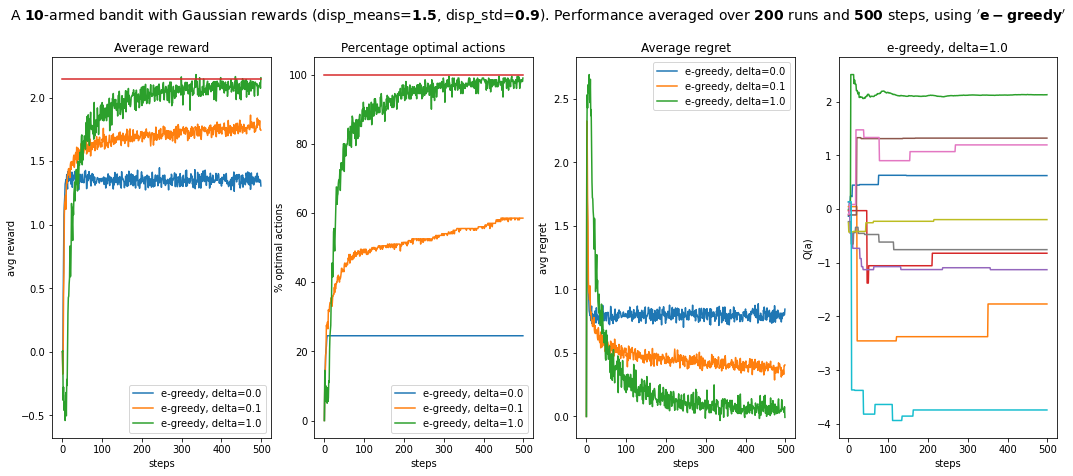

In [ ]:
run_bandits(dispStd = 0.9)

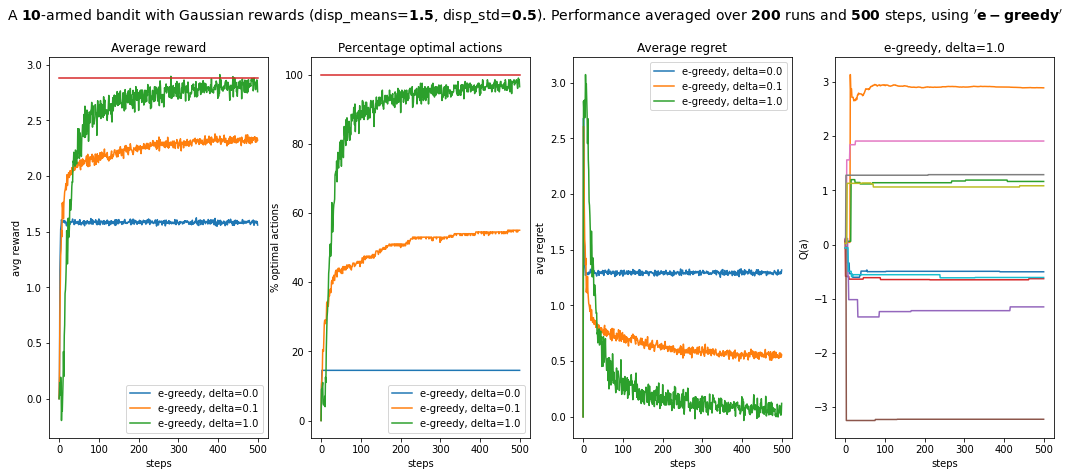

In [ ]:
run_bandits(dispStd = 0.5)

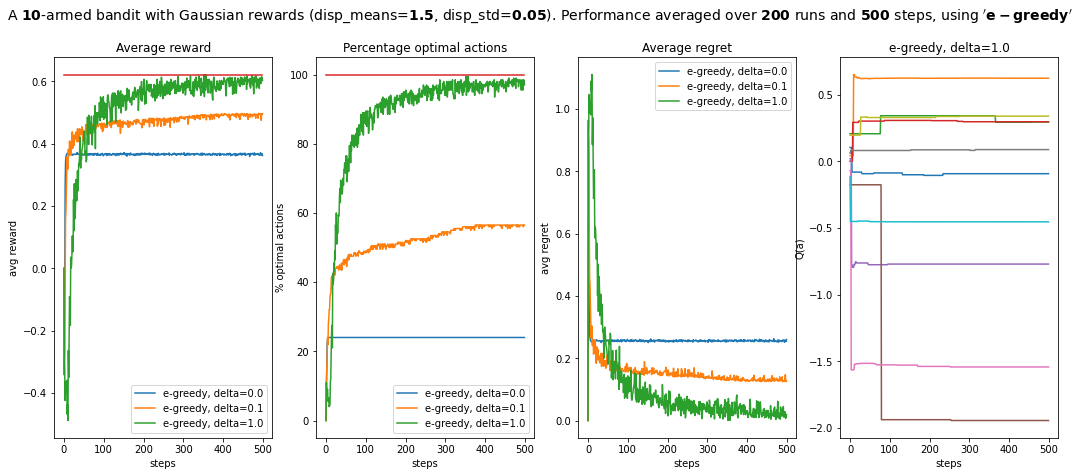

In [ ]:
run_bandits(dispStd = 0.05)

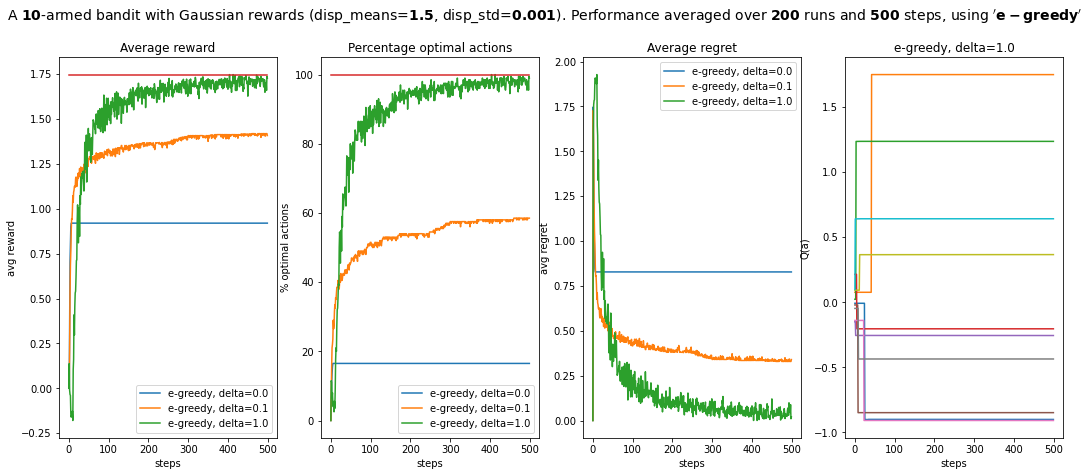

In [ ]:
run_bandits(dispStd = 0.001)

## b) Think of a practical application that can be modeled with an $m$-armed bandit. Guess a meaningful $f(r|a)$ $\forall a$ (Gaussian, binary Bernoulli, exponential, etc.) for that application. You may get some inspiration from [this paper](https://drive.google.com/file/d/1bOpOjRyHXAB91XF6uADV7tcWo2D2zHsK/view). Assume **stationarity** over time.

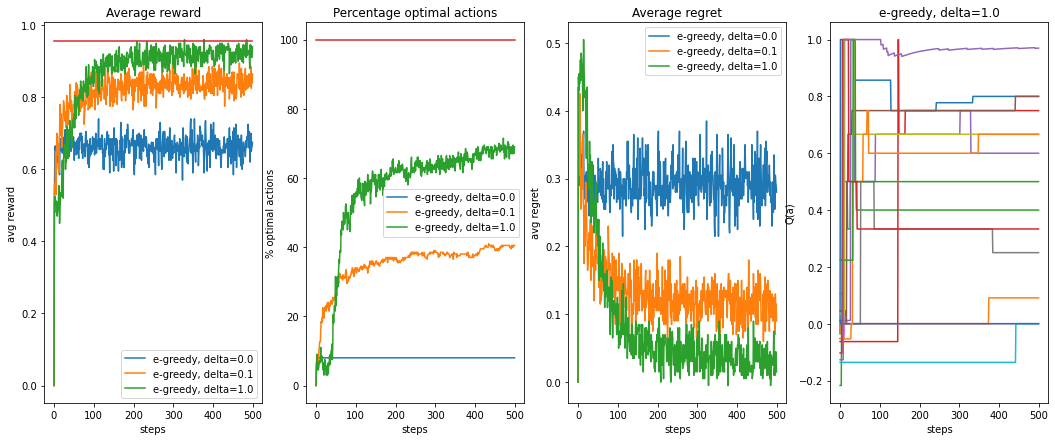

In [88]:
run_bandits(m = 15, bandit = 'bernoulli')

## c) Program it, use the base code provided, where Gaussian rewards have been assumed.

- Already DONE in modified code above.

## d) Check the average reward obtained in convergence for several values of the parameter associated to the UCB technique. Check also the number of correct decisions.

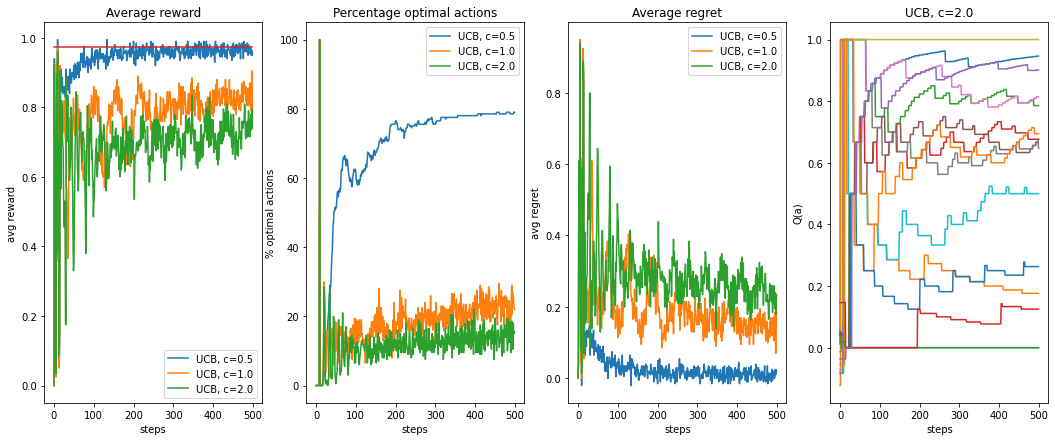

In [91]:
run_bandits(m = 15, bandit = 'bernoulli', strategy = 'UCB')

## e) Plot the rewards for every action on a single run.

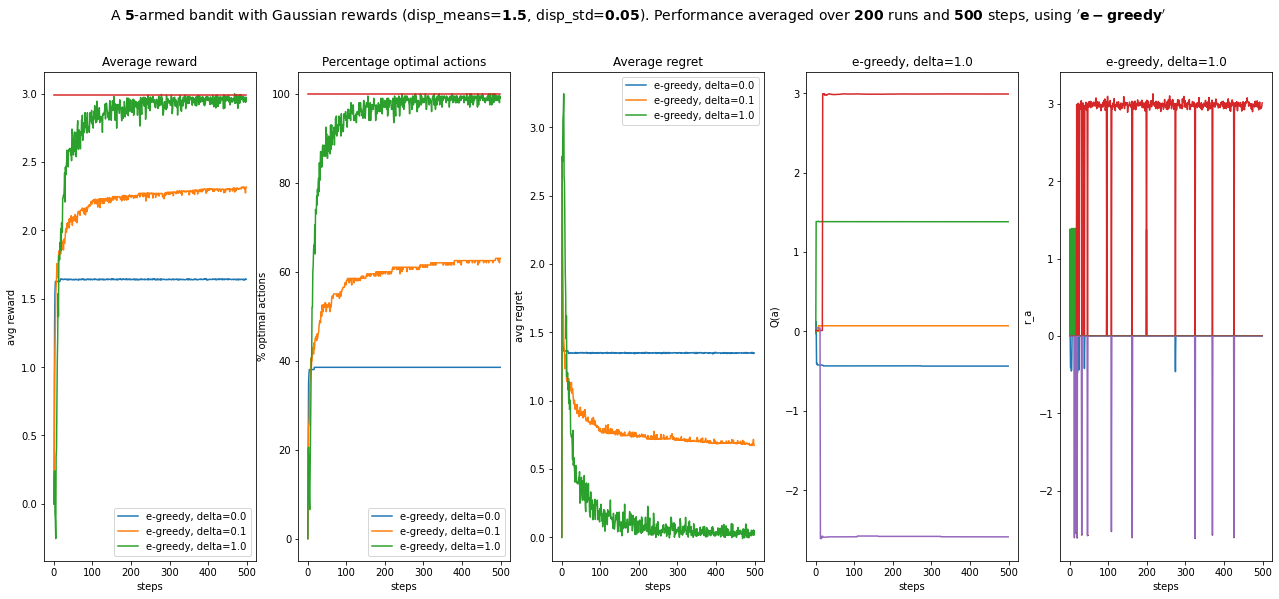

In [81]:
run_bandits(m = 5, rewards = True)

## f) Plot the evolution of regret.

- Already DONE in all plots shown.

## g) Make the environment **non-stationary** and include the appropriate changes to allow the algorithms track the best decisions.

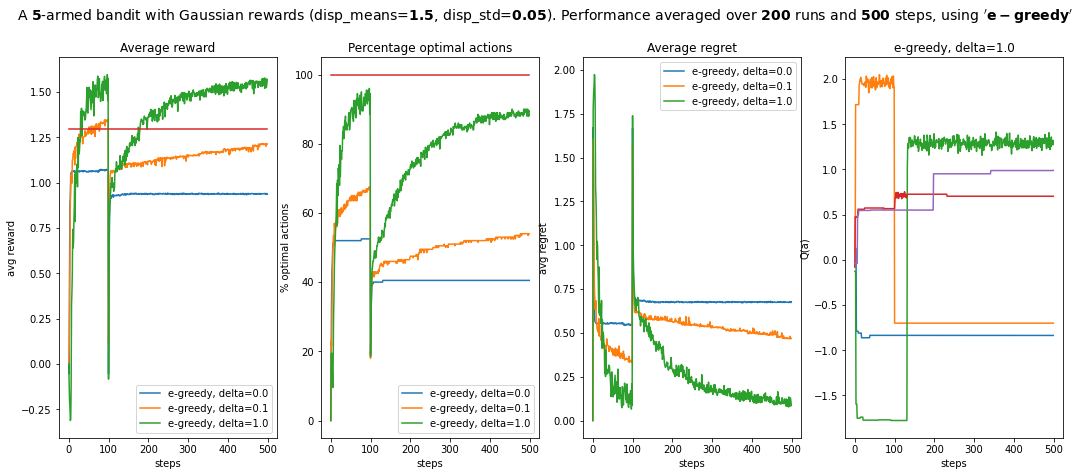

In [83]:
run_bandits(m = 5, stationary = False, alpha = 0.9)

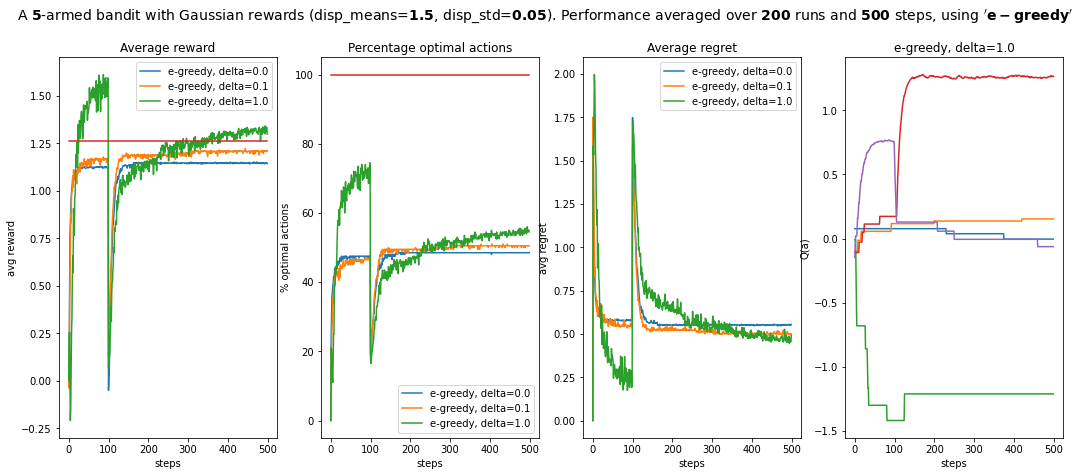

In [86]:
run_bandits(m = 5, stationary = False, alpha = 0.1)